In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz, mv_fisherz, gsq
from causallearn.utils.GraphUtils import GraphUtils

from DataFields import DataFields
from DataFields import DateReportedFields

from ProjectFunctions import convert_date_to_binary

##### Combine datasets

In [2]:
df_diagnosed = pd.read_csv("diagnosed_processed.csv")
df_undiagnosed = pd.read_csv("undiagnosed.csv")
df = pd.concat([df_diagnosed, df_undiagnosed], ignore_index=True, sort=False)
df = df[DateReportedFields]

##### Convert to time deltas + NA (fit for mv_fisherz test)

In [3]:
def convert_time_distance(df, target_feature: str) -> pd.DataFrame:
    
    target_dates = pd.to_datetime(df[target_feature], errors='coerce')

    df[target_feature] = target_dates.notna().map({True: 0.0, False: pd.NA})

    for feature in df.columns:
        if feature == target_feature:
            continue
        feature_dates = pd.to_datetime(df[feature], errors='coerce')
        df[feature] = (target_dates - feature_dates).dt.days / 365.25
        
    return df

relation_df = convert_time_distance(df, "Vascular Dementia Report Date")

relation_df = relation_df.apply(pd.to_numeric, errors='coerce')

pc_test = mv_fisherz

##### Convert to categorical time delta (fit for gsq test)

In [4]:
def encode_disease_relation(disease_date, vd_date):
    if pd.isna(vd_date):
        if pd.isna(disease_date):
            return -3  # neither diagnosed
        else:
            return -4  # disease diagnosed, VD not
    else:
        if pd.isna(disease_date):
            return -2  # VD diagnosed, disease not
        delta = (pd.to_datetime(disease_date) - pd.to_datetime(vd_date)).days
        if delta < 0:
            return -1
        elif delta == 0:
            return 0
        else:
            return 1

relation_df = df.apply(
    lambda col: df.apply(lambda row: encode_disease_relation(row[col.name], row['Vascular Dementia Report Date']), axis=1)
)
relation_df.head()

pc_test = gsq

##### Run PC algorithm

In [5]:
nodes = relation_df.columns.tolist()
cg = pc(relation_df.values, alpha=0.01, indep_test_func=pc_test, mvpc=False, verbose=False)

  0%|          | 0/17 [00:00<?, ?it/s]

##### Visualize output

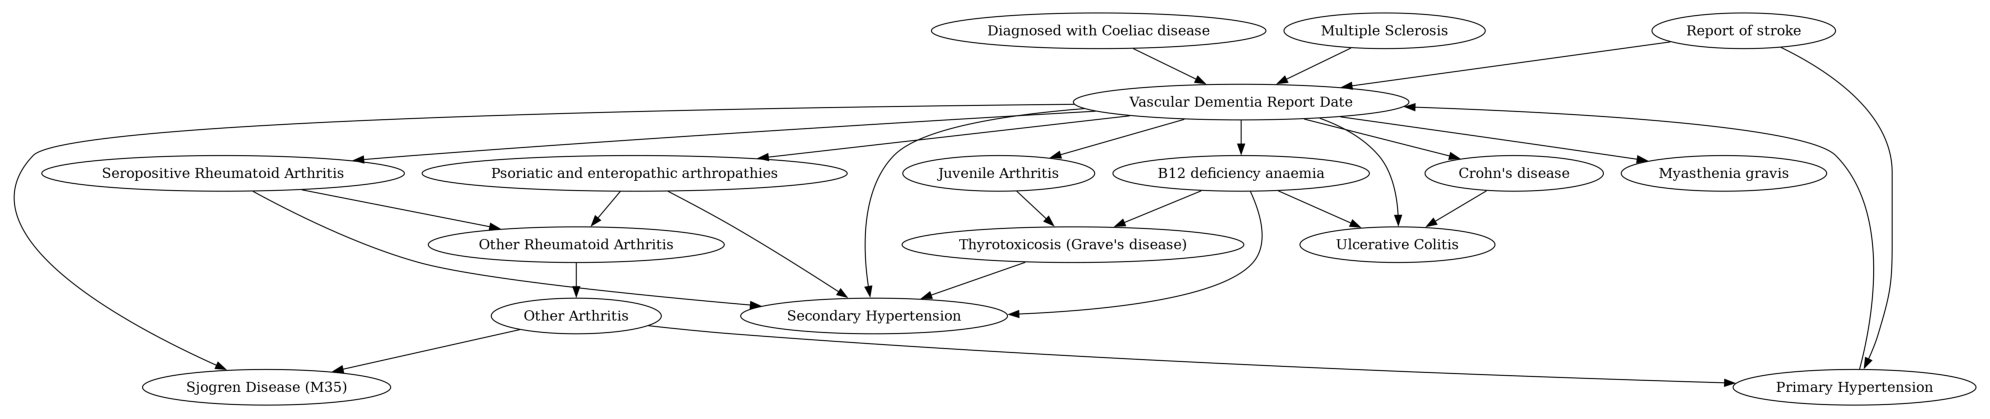

In [6]:
cg.draw_pydot_graph(labels=nodes)